In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile
import emoji

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
%matplotlib inline

In [2]:
url = 'http://0.0.0.0:8000/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  print('Found and verified %s' % filename, statinfo.st_size)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('foo.zip', 1633459)

Found and verified foo.zip 1633459
Found and verified foo.zip


In [3]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
#   stops = set(stopwords.words("english"))
  y = [emoji.demojize(x.translate(None, '?!,."').lower().decode('utf-8')).encode('ascii', 'ignore') for x in data]
  y = [ re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) for text in y ]
  y = [ re.sub(r'^\([A-Za-z0-9]*', '', text, flags=re.MULTILINE) for text in y ]
  y = [ re.sub(r'^@\w+', '', text, flags=re.MULTILINE) for text in y ]
#   y = [ x for x in y if not x in stops ]
  return filter(None, y)

words = read_data(filename)
print('Data size', len(words))

Data size 627065


In [4]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 25000 # 8-10 year old vocab

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0


Most common words (+UNK) [['UNK', 12732], ('the', 20439), ('to', 15162), ('i', 13551), ('a', 13551)]
Sample data [224, 234, 424, 224, 331, 35, 2026, 13, 110, 1574] ['hey', 'tom', '^^', 'hey', 'keep', 'me', 'posted', 'on', 'any', 'contract']


In [5]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print('len', len(reverse_dictionary))
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

len 25000
234 tom -> 424 ^^
234 tom -> 224 hey
424 ^^ -> 234 tom
424 ^^ -> 224 hey
224 hey -> 331 keep
224 hey -> 424 ^^
331 keep -> 224 hey
331 keep -> 35 me


In [6]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 200  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 128  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.6).minimize(loss)
#   optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)


  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.initialize_all_variables()

In [7]:
# Step 5: Begin training.
num_steps = 400001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("\n\nAverage loss at step ", step, ": ", average_loss, "\n\n")
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 4000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized


Average loss at step  0 :  267.384063721 


Nearest to your: hintjens', license), #done, thermometer, ctrl-chop-head-of-chicken-and-rage-quit, unfriended, emoji), carcavelos,
Nearest to for: replied, authorities, audit, datacentres, pushes, cloudshell, wales), atom-shell,
Nearest to very: monolith, seat, acquisitions, connections, ambiguous, 80%+, #superexcited, #dangerous,
Nearest to then: cyclists, pimp, burning, attacks, mat, stated, simonspringett@ntlworldcom, :cow:,
Nearest to so: apologises, exam, sword, concur, validated, checksumming, park, maida,
Nearest to where: fully, enable, casualty, darren, inputs, era, #no, unsafe,
Nearest to i'll: resource, behaviour, fallen, jk, haskell, consumerism, bacalhau, artist,
Nearest to was: pursue, rubber, go-lang, blankey, want:, 750ml, backers, presences,
Nearest to same: codes), :thumbs_down_sign::emoji_modifier_fitzpatrick_type-1-2:, co-exist, irssi, pencil, spreadsheets, stirred, func1,
Nearest to how: minerals, ththrough,

In [8]:
# Step 6: Visualize the embeddings.
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)
  plt.show()


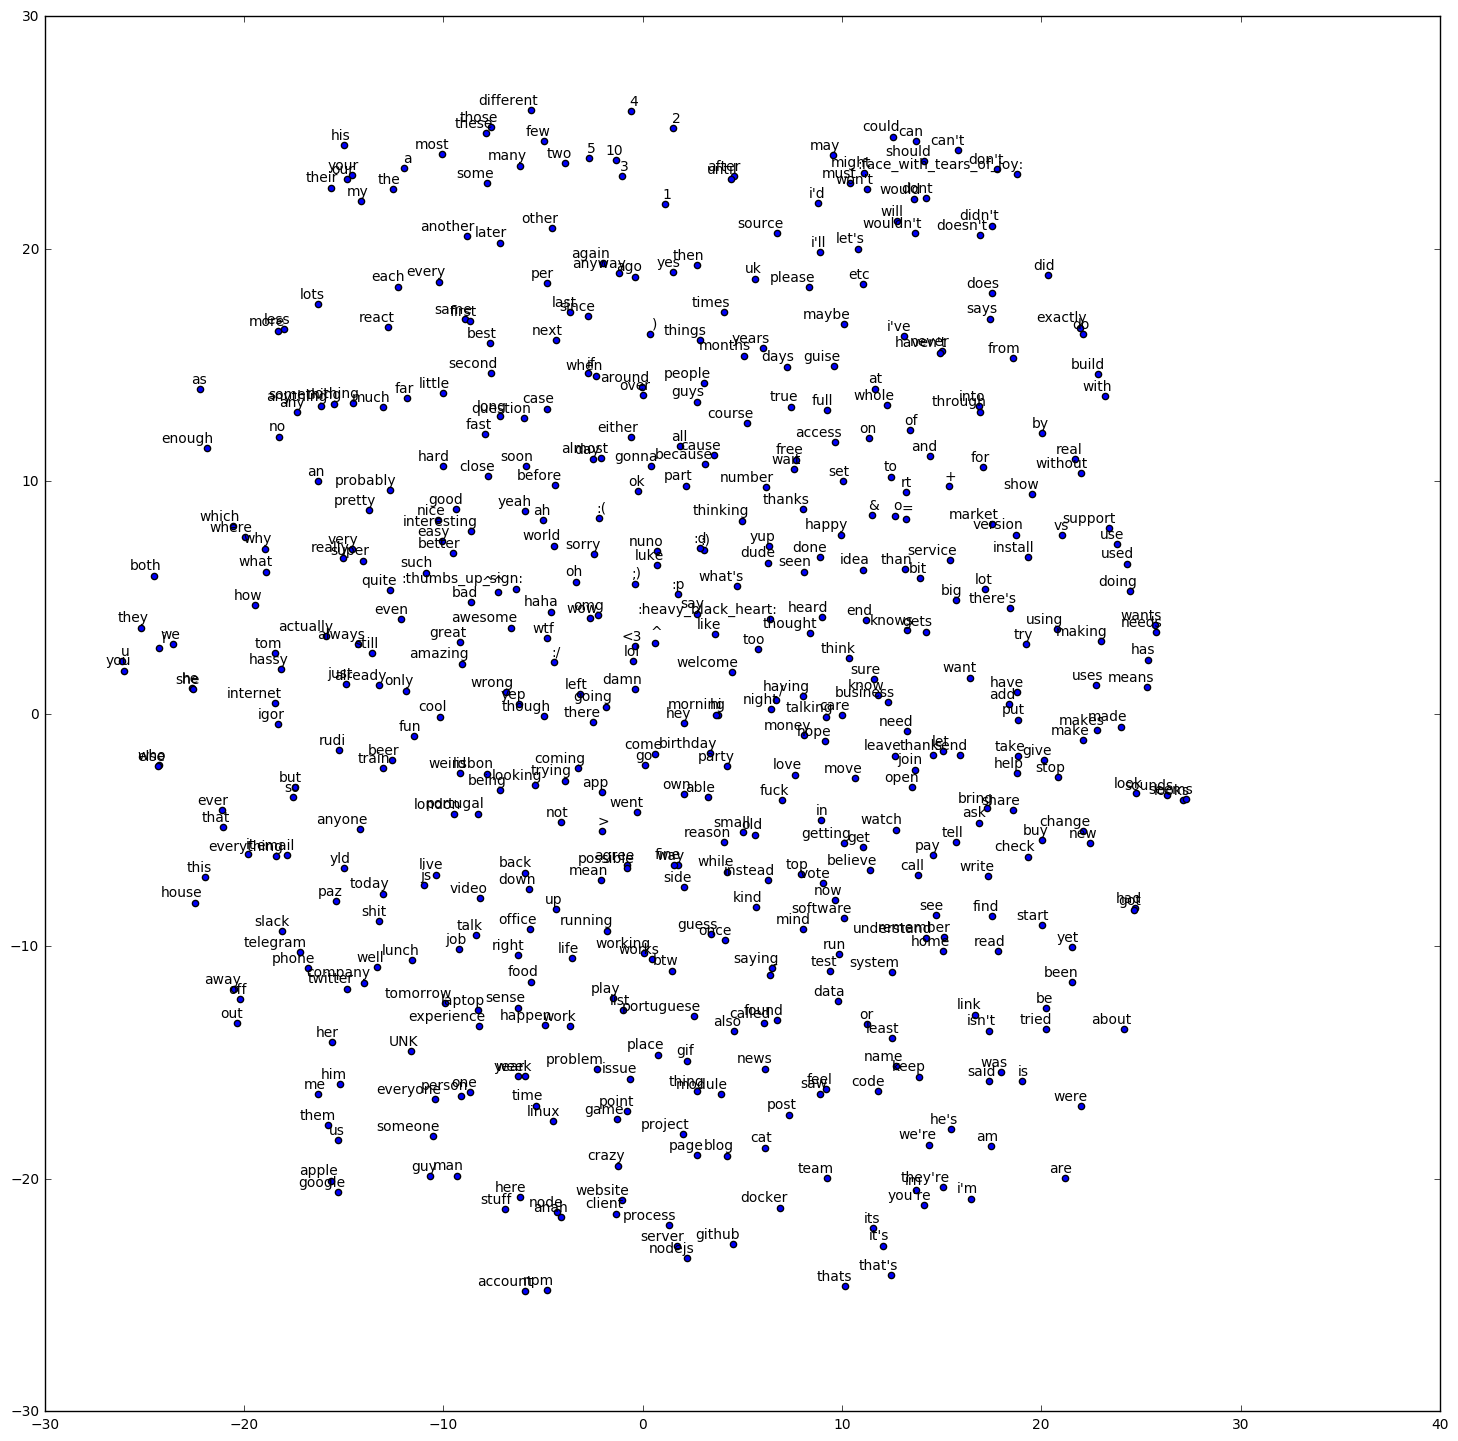

In [17]:
try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=15000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")